In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

from sklearn.model_selection import train_test_split


data_dir = 'dataset/traindata/'

import pickle
from sklearn.feature_selection import SelectKBest, f_classif

"""
Load class numbers associated with each image as one-hot vectors
"""
def load_classes(Y, encoding = 'onehot'):
    if encoding not in ['onehot', 'interval']:
        raise ValueError('incorrect type of encoding')
    df = pd.read_csv(os.path.join(data_dir, 'image2labels.tsv'), sep='\t', header = None, names = ['ImgName', 'ClassNum', 'ClassLabel'])
    image2class = pd.Series(df.ClassNum.values,index=df.ImgName).to_dict()
    max_class_num = np.max(list(image2class.values()))
    if encoding == 'onehot':
        Y_out = np.zeros((Y.shape[0], max_class_num+2))
        for ind,img in enumerate(Y):
            if img == 'none':
                Y_out[ind][max_class_num+1] = 1
            else:
                Y_out[ind][image2class[img]] = 1
    elif encoding == 'interval':
        Y_out = np.zeros((Y.shape[0],))
        for ind,img in enumerate(Y):
            if img == 'none':
                Y_out[ind] = max_class_num + 1
            else:
                Y_out[ind] = image2class[img]
    
    return Y_out
        

"""
Subtract the mean signal from the resting state data
"""
def rest_normalize(X,Y):
    with open('dataset/traindata/sample2session.p', 'rb') as f:
        sample2session = pickle.load(f)
    subjects = list(set(sample2session['Subject']))
    baseline = {}
    for sub in subjects:
        rest = np.array([x for ind,x in enumerate(X) if Y[ind][16] == 1 and sample2session['Subject'].values[ind] == sub])
        baseline[sub] = np.mean(rest, axis = (0,1))
    X_new = np.array([x - baseline[sample2session['Subject'].values[ind]] for ind,x in enumerate(X)])
    
    return X_new    
    

"""
Load in the dataset.

Return train, dev, test splits, standardized
"""
def load_data(dim_reduce = False, num_dims = 1000, split = True):
    # Load from disk
    with open(data_dir + 'X_raw.p', 'rb') as f:
        X = np.array(pickle.load(f))
    with open(data_dir + 'Y_raw.p', 'rb') as f:
        Yimages = np.array(pickle.load(f))
    if dim_reduce:
        classes = load_classes(Yimages, encoding = 'interval')
        X_mean = np.mean(X, axis=1)
        kbest = SelectKBest(f_classif, k = num_dims).fit(X_mean,classes)
        best_voxels = np.argsort(kbest.scores_)[::-1][:num_dims]
        X = X[:,:,best_voxels]
    # Convert class labels as one hot vectors
    classes = load_classes(Yimages)
    # Standardize data
    X_scaled = rest_normalize(X, classes)
    # Split into train,dev,test
    if split:
        X_train, X_devtest, Y_train, Y_devtest = train_test_split(X_scaled, classes, test_size = 0.4)
        X_dev, X_test, Y_dev, Y_test = train_test_split(X_devtest, Y_devtest, test_size = 0.5)

        print('%20s %20s' % ('Shape of X_train:', str(X_train.shape)))
        print('%20s %20s' % ('Shape of Y_train:', str(Y_train.shape)))
        print('%20s %20s' % ('Shape of X_dev:', str(X_dev.shape)))
        print('%20s %20s' % ('Shape of Y_dev:', str(Y_dev.shape)))
        print('%20s %20s' % ('Shape of X_test:', str(X_test.shape)))
        print('%20s %20s' % ('Shape of Y_test:', str(Y_test.shape)))

        return X_train, X_dev, X_test, Y_train, Y_dev, Y_test
    else:
        return X_scaled, classes

In [2]:
X, Y = load_data(dim_reduce = False, split = False)

X_tsne = np.array([np.mean(x[2:4, :], axis = 0) for x in X])
print(X_tsne.shape)
print(Y.shape)

(19380, 9598)
(19380, 17)


In [12]:
with open('dataset/traindata/sample2session.p', 'rb') as f:
    sample2session = pickle.load(f)

database = []
for num,row in sample2session.iterrows():
    if 'JPEG' in row['ImgName']:
        database.append('ImageNet')
    elif 'COCO' in row['ImgName']:
        database.append('COCO')
    elif 'none' in row['ImgName']:
        database.append('none')
    else:
        database.append('Scene')
sample2session['Database'] = database
sample2session

,ImgName,Run,SampleIndex,Session,Subject,Database
0,n03028079_7455.JPEG,1.0,0.0,5.0,sub-CSI2,ImageNet
1,COCO_train2014_000000505863.jpg,1.0,1.0,5.0,sub-CSI2,COCO
2,ShowJumping9.jpg,1.0,2.0,5.0,sub-CSI2,Scene
3,n03642806_6795.JPEG,1.0,3.0,5.0,sub-CSI2,ImageNet
4,COCO_train2014_000000485502.jpg,1.0,4.0,5.0,sub-CSI2,COCO
5,n02364673_9357.JPEG,1.0,5.0,5.0,sub-CSI2,ImageNet
6,n04418357_22691.JPEG,1.0,6.0,5.0,sub-CSI2,ImageNet
7,COCO_train2014_000000412200.jpg,1.0,7.0,5.0,sub-CSI2,COCO
8,n03777568_7670.JPEG,1.0,8.0,5.0,sub-CSI2,ImageNet
9,n09288635_24976.JPEG,1.0,9.0,5.0,sub-CSI2,ImageNet


In [13]:
with open('dataset/traindata/sample2session.p', 'wb') as f:
    pickle.dump(sample2session,f)

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

#X_pca = PCA(n_components=100).fit_transform(X_tsne)

X_transform = TSNE(verbose = 1).fit_transform(X_tsne)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 19380 samples in 24.254s...


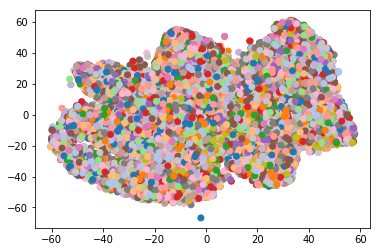

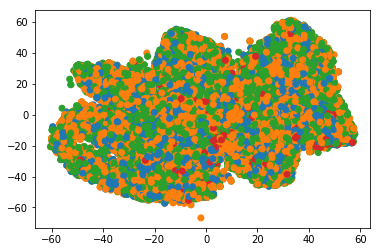

In [21]:
with open('dataset/traindata/sample2session.p', 'rb') as f:
    sample2session = pickle.load(f)

df = pd.read_csv(os.path.join(data_dir, 'image2labels.tsv'), sep='\t', header = None, names = ['ImgName', 'ClassNum', 'ClassLabel'])
image2class = pd.Series(df.ClassNum.values,index=df.ImgName).to_dict()

colors = plt.cm.tab20(np.arange(Y.shape[1]))
c1 = []
c2 = []
for num,row in sample2session.iterrows():
    img = row['ImgName']
    if img == 'none':
        c1.append(colors[16])
    else:
        c1.append(colors[image2class[img]])
    db = row['Database']
    if db == 'none':
        c2.append(colors[6])
    elif db == 'ImageNet':
        c2.append(colors[4])
    elif db == 'COCO':
        c2.append(colors[2])
    elif db == 'Scene':
        c2.append(colors[0])

plt.close('all')
plt.scatter(X_transform[:,0], X_transform[:,1], c = c1)
plt.show()

plt.close('all')
plt.scatter(X_transform[:,0], X_transform[:,1], c = c2)
plt.show()